
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/master?urlpath=lab/tree/ring_background.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/docs/tutorials).
- **Source files:**
[ring_background.ipynb](../_static/notebooks/ring_background.ipynb) |
[ring_background.py](../_static/notebooks/ring_background.py)
</div>


# Ring Background Estimation

## Context:
One of the challenges of IACT analysis is accounting for the large residual hadronic emission. An excess map, assumed to be a map of only gamma-ray events, requires a good estimate of the background.  However, in the absence of a solid template bkg model it is not possible to obtain reliable background model a priori. It was often found necessary in classical cherenkov astronomy to perform a local renormalization of the existing templates, usually with a ring kernel. This assumes that most of the events are background and requires to have an exclusion mask to remove regions with bright signal from the estimation. To read more about this method, see [here.](https://arxiv.org/abs/astro-ph/0610959)

## Objective:
Create an excess (gamma-ray events) map of MSH 15-52 as well as a significance map to determine how solid the signal is.

## Proposed approach:

The analysis workflow is roughly
 - Compute the sky maps keeping each observation separately using the `Analysis` class
 - Estimate the background using the `RingBackgroundMaker`
 - Compute the correlated excess and significance maps using the `CorrelatedExcessMapEstimator`
 
The normalised background thus obtained can be used for general modelling and fitting.

## Setup
As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
from regions import CircleSkyRegion
from scipy.stats import norm

import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.makers import RingBackgroundMaker
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import Map
from gammapy.datasets import MapDatasetOnOff

## Creating the config file
Now, we create a config file for out analysis. You may load this from disc if you have a pre-defined config file.

In this example, we will use a few HESS runs on the pulsar wind nebula, MSH 1552

In [3]:
# source_pos = SkyCoord.from_name("MSH 15-52")
source_pos = SkyCoord(228.32, -59.08, unit="deg")

In [4]:
config = AnalysisConfig()
# Select observations - 2.5 degrees from the source position
config.observations.datastore = "$GAMMAPY_DATA/hess-dl3-dr1/"
config.observations.obs_cone = {
    "frame": "icrs",
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "radius": 2.5 * u.deg,
}

In [5]:
config.datasets.type = "3d"
config.datasets.geom.wcs.skydir = {
    "lon": source_pos.ra,
    "lat": source_pos.dec,
    "frame": "icrs",
}  # The WCS geometry - centered on MSH 15-52
config.datasets.geom.wcs.fov = {"width": "3 deg", "height": "3 deg"}
config.datasets.geom.wcs.binsize = "0.02 deg"

# The FoV radius to use for cutouts
config.datasets.geom.selection.offset_max = 3.5 * u.deg

# We now fix the energy axis for the counts map - (the reconstructed energy binning)
config.datasets.geom.axes.energy.min = "0.5 TeV"
config.datasets.geom.axes.energy.max = "5 TeV"
config.datasets.geom.axes.energy.nbins = 10

# We need to extract the ring for each observation separately, hence, no stacking at this stage
config.datasets.stack = False

In [6]:
print(config)

AnalysisConfig

    general:
        log: {level: info, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 228.32 deg, lat: -59.08 deg, radius: 2.5 deg}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir: {frame: icrs, lon: 228.32 deg, lat: -59.08 deg}
                binsize: 0.02 deg
                fov: {width: 3.0 deg, height: 3.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 5.0 TeV, nbins: 10}
                energy_true: {min: 0.1 TeV, max: 10.0 TeV, nbins: 30}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
            pa

## Getting the reduced dataset
We now use the config file to do the initial data reduction which will then be used for a ring extraction

In [7]:
%%time
# create the config
analysis = Analysis(config)

# for this specific case,w e do not need fine bins in true energy
analysis.config.datasets.geom.axes.energy_true = (
    analysis.config.datasets.geom.axes.energy
)

# `First get the required observations
analysis.get_observations()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Number of selected observations: 20


CPU times: user 217 ms, sys: 8.39 ms, total: 225 ms
Wall time: 217 ms


In [8]:
print(analysis.config)

AnalysisConfig

    general:
        log: {level: INFO, filename: null, filemode: null, format: null, datefmt: null}
        outdir: .
    observations:
        datastore: $GAMMAPY_DATA/hess-dl3-dr1
        obs_ids: []
        obs_file: null
        obs_cone: {frame: icrs, lon: 228.32 deg, lat: -59.08 deg, radius: 2.5 deg}
        obs_time: {start: null, stop: null}
    datasets:
        type: 3d
        stack: false
        geom:
            wcs:
                skydir: {frame: icrs, lon: 228.32 deg, lat: -59.08 deg}
                binsize: 0.02 deg
                fov: {width: 3.0 deg, height: 3.0 deg}
                binsize_irf: 0.2 deg
            selection: {offset_max: 3.5 deg}
            axes:
                energy: {min: 0.5 TeV, max: 5.0 TeV, nbins: 10}
                energy_true: {min: 0.5 TeV, max: 5.0 TeV, nbins: 10}
        map_selection: [counts, exposure, background, psf, edisp]
        background:
            method: null
            exclusion: null
            par

In [9]:
%%time
# Data extraction
analysis.get_datasets()

Creating geometry.
Creating datasets.
No background maker set for 3d analysis. Check configuration.
Processing observation 20365
Processing observation 20366
Processing observation 20367
Processing observation 20368
Processing observation 20136
Processing observation 20137
Processing observation 20151
Processing observation 20282
Processing observation 20283
Processing observation 20301
Processing observation 20302
Processing observation 20303
Processing observation 20322
Processing observation 20323
Processing observation 20324
Processing observation 20325
Processing observation 20343
Processing observation 20344
Processing observation 20345
Processing observation 20346


CPU times: user 15 s, sys: 944 ms, total: 16 s
Wall time: 16 s


## Extracting the ring background

Since the ring background is extracted from real off events, we need to use the wstat statistics in this case. For this, we will use the `MapDatasetOnOFF` and the `RingBackgroundMaker` classes.

### Create exclusion mask
First, we need to create an exclusion mask on the known sources. In this case, we need to mask only `MSH 15-52` but this depends on the sources present in our field of view.

(<Figure size 432x288 with 1 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension', ylabel='Declination'>,
 None)

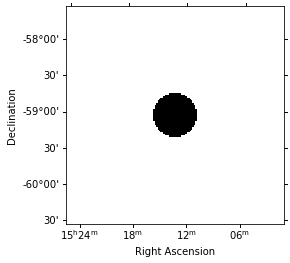

In [10]:
# get the geom that we use
geom = analysis.datasets[0].counts.geom
energy_axis = analysis.datasets[0].counts.geom.axes["energy"]
geom_image = geom.to_image().to_cube([energy_axis.squash()])

# Make the exclusion mask
regions = CircleSkyRegion(center=source_pos, radius=0.3 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
exclusion_mask.sum_over_axes().plot();

For the present analysis, we use a ring with an inner radius of 0.5 deg and width of 0.3 deg.

In [11]:
ring_maker = RingBackgroundMaker(
    r_in="0.5 deg", width="0.3 deg", exclusion_mask=exclusion_mask
)

### Create a stacked dataset
Now, we extract the background for each dataset and then stack the maps together to create a single stacked map for further analysis

In [12]:
#%%time
energy_axis_true = analysis.datasets[0].exposure.geom.axes["energy_true"]
stacked_on_off = MapDatasetOnOff.create(
    geom=geom_image, energy_axis_true=energy_axis_true, name="stacked"
)

for dataset in analysis.datasets:
    # Ring extracting makes sense only for 2D analysis
    dataset_on_off = ring_maker.run(dataset.to_image())
    stacked_on_off.stack(dataset_on_off)

/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


This `stacked_on_off` has `on` and `off` counts and acceptance maps which we will use in all further analysis. The `acceptance` and `acceptance_off` maps are the system acceptance of gamma-ray like events in the `on` and `off` regions respectively.

In [13]:
print(stacked_on_off)

MapDatasetOnOff
---------------

  Name                            : stacked 

  Total counts                    : 39183 
  Total background counts         : 38320.57
  Total excess counts             : 862.43

  Predicted counts                : 38320.92
  Predicted background counts     : 38320.92
  Predicted excess counts         : nan

  Exposure min                    : 1.11e+09 m2 s
  Exposure max                    : 1.30e+10 m2 s

  Number of total bins            : 22500 
  Number of fit bins              : 22500 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 26399.35

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  Total counts_off                : 86301192 
  Acceptance                      : 22500 
  Acceptance off                  : 49478073 



/usr/share/miniconda/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


## Compute correlated significance and correlated excess maps
We need to convolve our maps with an apprpriate smoothing kernel. The significance is computed according to the Li & Ma expression for ON and OFF Poisson measurements, see [here](https://ui.adsabs.harvard.edu/abs/1983ApJ...272..317L/abstract). Since astropy convolution kernels only accept integers, we first convert our required size in degrees to int depending on our pixel size.

In [14]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(stacked_on_off)

In [15]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <WCSAxesSubplot:title={'center':'Excess map'}, xlabel='Right Ascension', ylabel='Declination'>,
 <matplotlib.colorbar.Colorbar at 0x7f9ce1c43be0>)

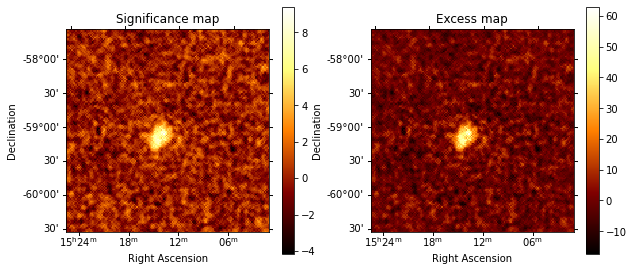

In [16]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

It is often important to look at the signficance distribution outside the exclusion region to check that the background estimation is not contaminated by gamma-ray events. This can be the case when exclusion regions are not large enough.
Typically, we expect the off distribution to be a standard normal distribution.

Fit results: mu = -0.02, std = 1.00


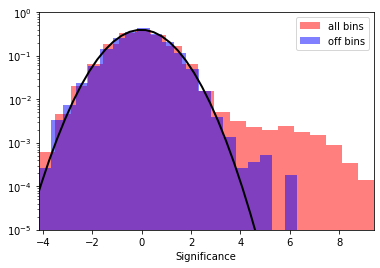

In [17]:
# create a 2D mask for the images
significance_map_off = significance_map * exclusion_mask
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print(f"Fit results: mu = {mu:.2f}, std = {std:.2f}")